mpi4py is not available. You must install it


Operator `initdamp` ran in 0.01 s


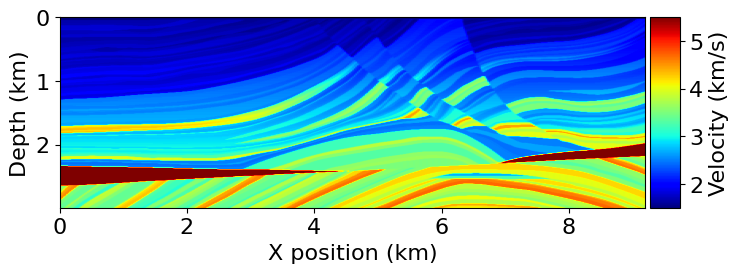

In [1]:
from examples.seismic import Model, plot_velocity
from devito import *
import numpy as np
import matplotlib as plt

nx = 369
nz = 375
nbl = 100
nshots = 151
space_order = 8
dtype = np.float32
shape = (nx, nz)
spacing = (25., 8.)
origin = (0., 0.)



v = np.empty(shape, dtype=dtype)


path = "model-375.cwp"
a = open(path)
v = np.fromfile(a, dtype=dtype).reshape([nx, nz])
v=v/1000
model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=space_order, nbl=nbl, bcs="damp")

plot_velocity(model)


Operator `initdamp` ran in 0.01 s


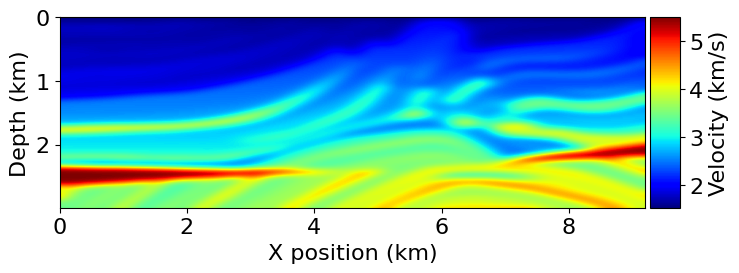

In [2]:
model0 = Model(space_order=space_order, vp=v,   
                           origin=origin, shape=shape, spacing=spacing, 
                           nbl=nbl)
filter_sigma = (6, 6)
gaussian_smooth(model0.vp, sigma=filter_sigma)

plot_velocity(model0)

In [3]:
from examples.seismic import TimeAxis

t0 = 0. 
tn = 5000.
dt = 0.0008
time_range = TimeAxis(start = t0, stop = tn, step = dt)



In [4]:
from examples.seismic import RickerSource

f0 = 0.015
src = RickerSource(name='src', grid=model.grid, f0=f0, npoint=1, time_range=time_range)
src.coordinates.data[0, :] = np.array(model.domain_size) * .5
src.coordinates.data[0, -1] = 1.


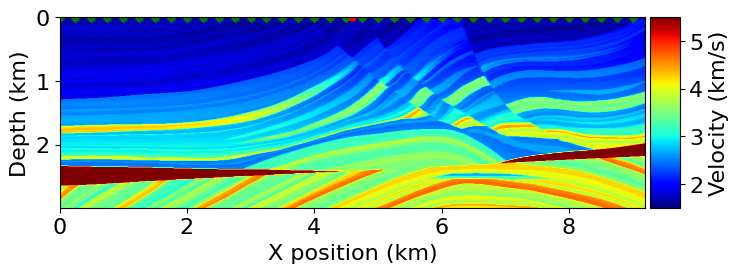

In [5]:
from examples.seismic import Receiver

rec_coordinates = np.empty((model.shape[0], 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=model.shape[0])
rec_coordinates[:, 1] = 1.

plot_velocity(model, source=src.coordinates.data,receiver=rec_coordinates[::10,:])

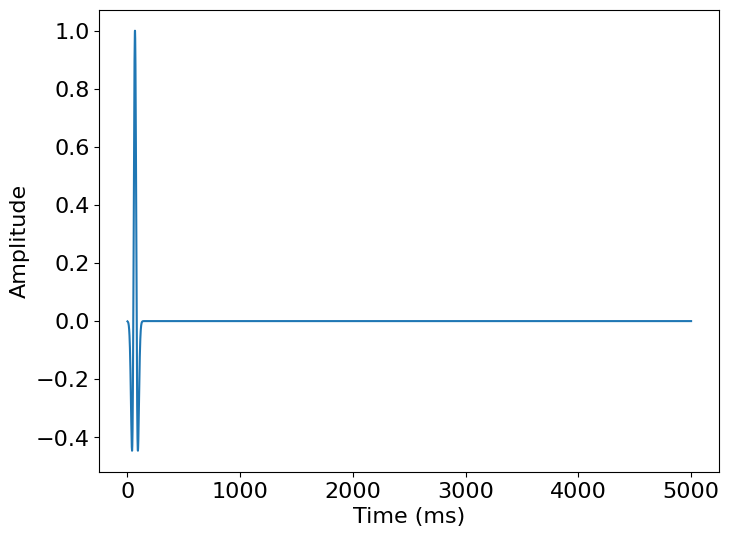

In [6]:
from examples.seismic import AcquisitionGeometry

geometry = AcquisitionGeometry(model, rec_coordinates, src.coordinates.data, t0, tn, f0=f0, src_type='Ricker')
geometry.src.show()

In [7]:
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

solver = AcousticWaveSolver(model, geometry, space_order=space_order)
true_d , _, _ = solver.forward(vp=model.vp)
smooth_d, _, _ = solver.forward(vp=model0.vp)

Operator `Forward` ran in 1.14 s
Operator `Forward` ran in 1.11 s


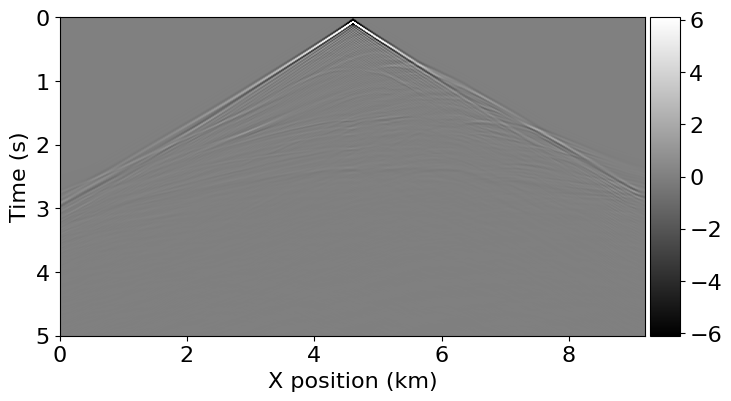

In [8]:

plot_shotrecord(true_d.data, model, t0, tn)

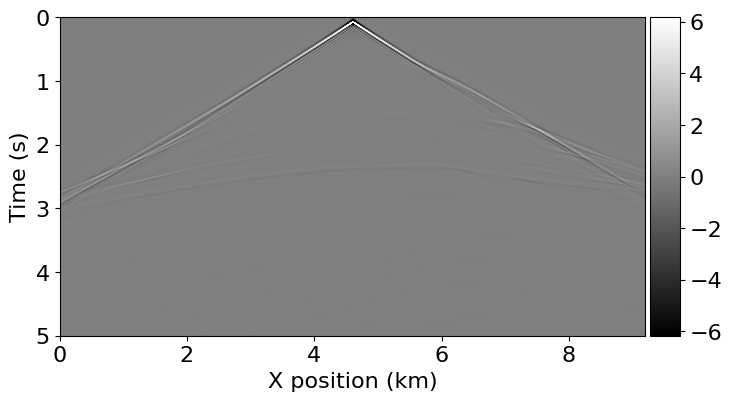

In [9]:
plot_shotrecord(smooth_d.data, model, t0, tn)

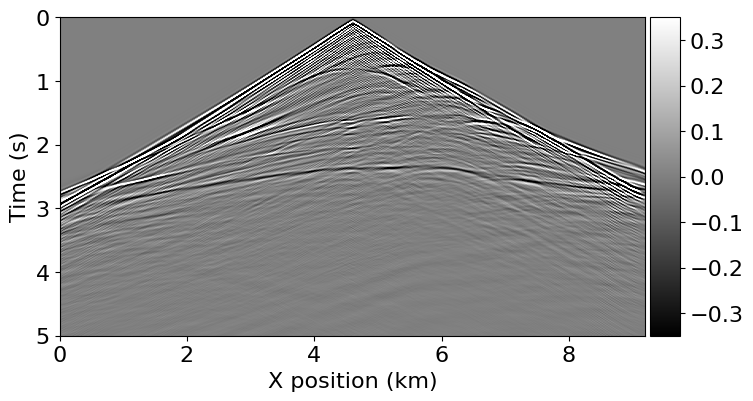

In [10]:
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

In [11]:

from examples.seismic import PointSource

def ImagingOperator(model, image):
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
    u = TimeFunction(name='u', grid=model.grid, time_order=2, space_order=space_order, save=geometry.nt)
    
    eqn = model.m * v.dt2 - v.laplace + model.damp * v.dt.T
    stencil = Eq(v.backward, solve(eqn, v.backward))
    
    dt = model.critical_dt
    residual = PointSource(name='residual', grid=model.grid,
                           time_range=geometry.time_axis,
                           coordinates=geometry.rec_positions)    
    res_term = residual.inject(field=v.backward, expr=residual * dt**2 / model.m)
    image_update = Eq(image, image - u * v)

    return Operator([stencil] + res_term + [image_update], subs=model.spacing_map)


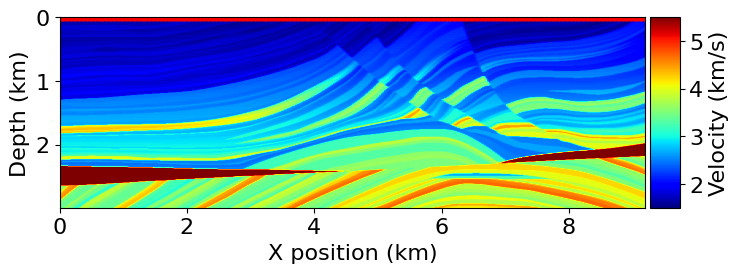

In [12]:
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = np.linspace(0., model.domain_size[0], num=nshots)
source_locations[:, 1] = 1

plot_velocity(model, source=source_locations)

In [13]:

image = Function(name='image', grid=model.grid,space_order=space_order)
op_imaging = ImagingOperator(model, image)

for i in range(nshots):
    print('Imaging source %d out of %d' % (i+1, nshots))
    geometry.src_positions[0, :] = source_locations[i, :]
    true_d, _, _ = solver.forward(vp=model.vp)
    smooth_d, u0, _ = solver.forward(vp=model0.vp, save=True)
    v = TimeFunction(name='v', grid=model.grid, time_order=2, space_order=space_order)
    residual = smooth_d.data - true_d.data
    op_imaging(u=u0, v=v, vp=model0.vp, dt=model0.critical_dt, residual=residual)


Imaging source 1 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.10 s
Operator `Kernel` ran in 1.51 s


Imaging source 2 out of 151


Operator `Forward` ran in 1.06 s
Operator `Forward` ran in 1.09 s
Operator `Kernel` ran in 1.40 s


Imaging source 3 out of 151


Operator `Forward` ran in 1.05 s
Operator `Forward` ran in 1.09 s
Operator `Kernel` ran in 1.40 s


Imaging source 4 out of 151


Operator `Forward` ran in 1.06 s
Operator `Forward` ran in 1.09 s
Operator `Kernel` ran in 1.40 s


Imaging source 5 out of 151


Operator `Forward` ran in 1.06 s
Operator `Forward` ran in 1.09 s
Operator `Kernel` ran in 1.40 s


Imaging source 6 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.10 s
Operator `Kernel` ran in 1.40 s


Imaging source 7 out of 151


Operator `Forward` ran in 1.15 s
Operator `Forward` ran in 1.10 s
Operator `Kernel` ran in 1.41 s


Imaging source 8 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.10 s
Operator `Kernel` ran in 1.40 s


Imaging source 9 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.40 s


Imaging source 10 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 11 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 12 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 13 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 14 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 15 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.16 s
Operator `Kernel` ran in 1.53 s


Imaging source 16 out of 151


Operator `Forward` ran in 1.17 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 17 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.44 s


Imaging source 18 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 19 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 20 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 21 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 22 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 23 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 24 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 25 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 26 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 27 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 28 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.12 s
Operator `Kernel` ran in 1.42 s


Imaging source 29 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 30 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 31 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 32 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 33 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.12 s
Operator `Kernel` ran in 1.42 s


Imaging source 34 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 35 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 36 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 37 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 38 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 39 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 40 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 41 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 42 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 43 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.16 s
Operator `Kernel` ran in 1.44 s


Imaging source 44 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 45 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 46 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 47 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 48 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 49 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 50 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 51 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 52 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 53 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 54 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 55 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 56 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 57 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 58 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 59 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 60 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 61 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 62 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.47 s


Imaging source 63 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 64 out of 151


Operator `Forward` ran in 1.12 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 65 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 66 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 67 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 68 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 69 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 70 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 71 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 72 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 73 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 74 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 75 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 76 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 77 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 78 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 79 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 80 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 81 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 82 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 83 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 84 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 85 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 86 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 87 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 88 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 89 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 90 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.44 s


Imaging source 91 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 92 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 93 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 94 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.52 s


Imaging source 95 out of 151


Operator `Forward` ran in 1.11 s
Operator `Forward` ran in 1.12 s
Operator `Kernel` ran in 1.42 s


Imaging source 96 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 97 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 98 out of 151


Operator `Forward` ran in 1.16 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.47 s


Imaging source 99 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 100 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 101 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 102 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 103 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 104 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 105 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 106 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 107 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 108 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 109 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.61 s


Imaging source 110 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 111 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 112 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 113 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.19 s
Operator `Kernel` ran in 1.45 s


Imaging source 114 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 115 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 116 out of 151


Operator `Forward` ran in 1.11 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 117 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 118 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 119 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 120 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 121 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 122 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 123 out of 151


Operator `Forward` ran in 1.17 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 124 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 125 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 126 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 127 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 128 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 129 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 130 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 131 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 132 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 133 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 134 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 135 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 136 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 137 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 138 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 139 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.41 s


Imaging source 140 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.12 s
Operator `Kernel` ran in 1.42 s


Imaging source 141 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 142 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 143 out of 151


Operator `Forward` ran in 1.12 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 144 out of 151


Operator `Forward` ran in 1.09 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 145 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 146 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.48 s


Imaging source 147 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 148 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.43 s


Imaging source 149 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 150 out of 151


Operator `Forward` ran in 1.07 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Imaging source 151 out of 151


Operator `Forward` ran in 1.08 s
Operator `Forward` ran in 1.11 s
Operator `Kernel` ran in 1.42 s


Original data shape: (449, 454)
Clipping low values below -459586.65625 and high values above 182705.23438.


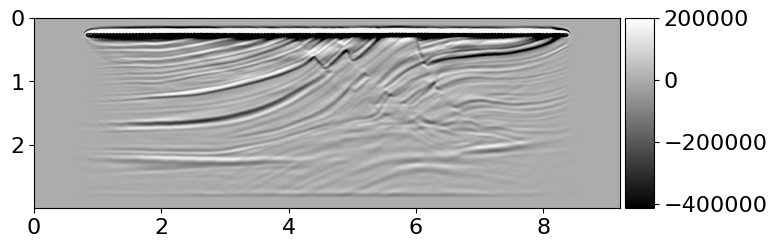

In [14]:
from examples.seismic.plot_model_mod import plot_image2
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (449, 454)
Clipping low values below -459586.65625 and high values above 182705.23438.


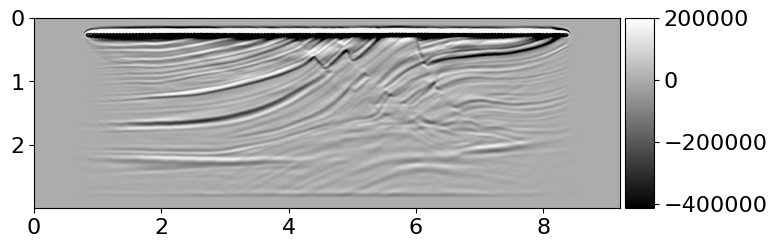

In [15]:
plot_image2(np.diff(image.data, axis=1),model,clip_percent=98,clip_low=2)


Original data shape: (369, 374)
Clipping low values below -625491.87500 and high values above 118537.92969.


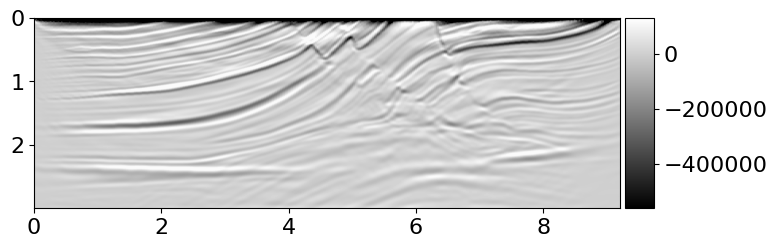

In [16]:
sliced_image = image.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(np.diff(sliced_image, axis=1),model,clip_percent=98,clip_low=2)


In [17]:
laplace_result = Function(name='lap',grid=model.grid, space_order=space_order)
stencil = Eq(laplace_result, image.laplace)
op = Operator([stencil])
op.apply()

Operator `Kernel` ran in 0.01 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=0.000137, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

Original data shape: (449, 455)
Clipping low values below -1150.90186 and high values above 3006.44458.


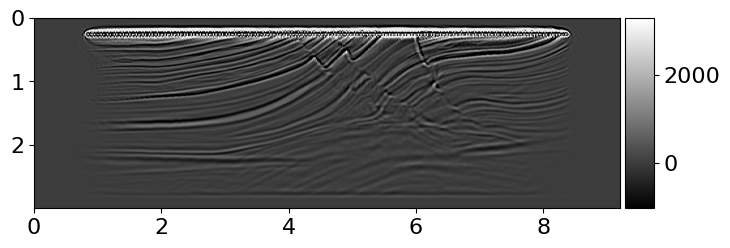

In [18]:
plot_image2(laplace_result.data,model,clip_percent=98,clip_low=2)


Original data shape: (369, 375)
Clipping low values below -989.97040 and high values above 1578.23083.


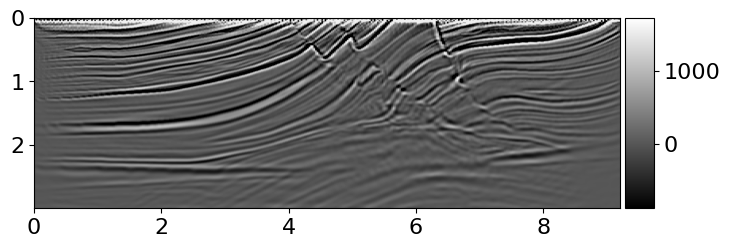

In [19]:
sliced_laplace = laplace_result.data[model.nbl:-model.nbl, model.nbl:-model.nbl]
plot_image2(sliced_laplace,model,clip_percent=98,clip_low=2)
